Generamos los permisos para acceder a nuestro drive donde encontraremos nuestro dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Introducimos la ruta para tener nuestro dataset cargado de forma correcta

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Cargamos el dataset
data = pd.read_csv('/content/drive/MyDrive/Practica7/Nuevo_Dataset_Patrones_Emocionales.csv')

Generamos nuestro diccionario para poder mapear las emociones de forma correcta y posteriormente construir la lista para mostrarse

In [ ]:
# Diccionario para mapear columnas a emociones
pregunta_a_emocion = {
    '1.  Recuerda un momento en el que lograste algo que realmente deseabas. ¿Cómo fue la experiencia y qué impacto tuvo en tu vida? ': 'Felicidad',
    '2. Describe una ocasión en la que alguien hizo algo especial o inesperado por ti y te hizo sentir bien. ¿Cómo reaccionaste? ': 'Felicidad',
    '3. Piensa en una ocasión en la que perdiste algo o a alguien importante para ti. ¿Cómo viviste ese momento y qué cambió después de ello? ': 'Tristeza',
    '4. Recuerda un día en el que sentiste que todo te salía mal. ¿Qué sucedió y cómo te sentiste al respecto? ': 'Tristeza',
    '5. Describe una situación en la que experimentaste algo que te resultó desagradable y quisiste evitar. ¿Cómo fue ese momento? ': 'Disgusto',
    '6. Recuerda una ocasión en la que viste o viviste algo que te pareció totalmente inaceptable. ¿Cómo reaccionaste y qué pensaste al respecto? ': 'Disgusto',
    '7. Piensa en un momento en el que sentiste que alguien fue injusto contigo. ¿Qué ocurrió y cómo reaccionaste? ': 'Ira',
    '8. Describe una ocasión en la que te sentiste frustrado(a) porque no tomaron en cuenta tu opinión o esfuerzo. ¿Cómo reaccionaste ante esta situación y cómo la manejaste? ': 'Ira',
    '9. Recuerda una ocasión en la que tuviste que enfrentarte a algo incierto o desconocido. ¿Cómo fue la experiencia y qué sentiste en ese momento? ': 'Miedo',
    '10. Describe un evento en el que sentiste que algo estaba fuera de tu control y no sabías qué hacer. ¿Cómo reaccionaste y qué pasó después? ': 'Miedo',
    '11. Piensa en un momento en el que ocurrió algo totalmente inesperado en tu vida. ¿Cómo fue y qué pasó después? ': 'Sorpresa',
    '12. Recuerda una ocasión en la que recibiste una noticia o viviste un evento que nunca imaginaste. ¿Cómo reaccionaste y qué impacto tuvo en ti?': 'Sorpresa'
}

# Construir lista de pares (texto, emoción)
data_pairs = []
for col, emocion in pregunta_a_emocion.items():
    if col in data.columns:
        for respuesta in data[col].dropna():
            respuesta_str = str(respuesta).strip()
            if respuesta_str != "":
                data_pairs.append((respuesta_str, emocion))
    else:
        print(f"Columna no encontrada: {col}")

# Crear nuevo DataFrame
df = pd.DataFrame(data_pairs, columns=["Texto", "Emocion"])

# Verificar estructura
df.head()

,Texto,Emocion
0,"Me sentí realmente feliz, muy emocionado de ha...",Felicidad
1,Me contrataron en una empresa como desarrollad...,Felicidad
2,Satisfacción y que con trabajo se logra todo,Felicidad
3,"Gratificante, aprendí mucho y felicidad",Felicidad
4,"Me sentí feliz y realizado, impacto mi vida ha...",Felicidad


Guardamos nuestro dataset limpio en un nuevo csv

In [ ]:
# Ruta donde guardarás el nuevo dataset limpio
ruta_guardado = "/content/drive/MyDrive/Practica7/Dataset_Emociones_Limpio.csv"

# Guardar
df.to_csv(ruta_guardado, index=False, encoding="utf-8-sig")
print(f"Dataset guardado correctamente en: {ruta_guardado}")

Dataset guardado correctamente en: /content/drive/MyDrive/Practica7/Dataset_Emociones_Limpio.csv


Aplicamos limpieza al eliminar las stopwords y stemming

In [ ]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# Descargar solo lo necesario
nltk.download("stopwords")

# Cargar stopwords y stemmer en español
stop_words = set(stopwords.words("spanish"))
stemmer = SnowballStemmer("spanish")

# Función de preprocesamiento sin nltk.word_tokenize
def preprocesar_texto(texto):
    texto = texto.lower()
    texto = re.sub(r"[^a-záéíóúüñ\s]", "", texto)  # eliminar puntuación
    tokens = texto.split()  # tokenización simple
    tokens = [stemmer.stem(t) for t in tokens if t not in stop_words]
    return " ".join(tokens)

# Aplicar al dataset
df["Texto_Limpio"] = df["Texto"].apply(preprocesar_texto)

# Visualizar ejemplos
df[["Texto", "Texto_Limpio", "Emocion"]].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Texto,Texto_Limpio,Emocion
0,"Me sentí realmente feliz, muy emocionado de ha...",sent realment feliz emocion hab consegu anhel ...,Felicidad
1,Me contrataron en una empresa como desarrollad...,contrat empres desarroll softwar senti orgull ...,Felicidad
2,Satisfacción y que con trabajo se logra todo,satisfaccion trabaj logr,Felicidad
3,"Gratificante, aprendí mucho y felicidad",gratif aprend felic,Felicidad
4,"Me sentí feliz y realizado, impacto mi vida ha...",sent feliz realiz impact vid hac person disciplin,Felicidad


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

# Separar datos
X = df["Texto_Limpio"]
y = df["Emocion"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Modelos a comparar
modelos = {
    "SVM (LinearSVC)": LinearSVC(),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

# Entrenamiento y evaluación
for nombre, modelo in modelos.items():
    pipeline = Pipeline([
        ("tfidf", TfidfVectorizer()),
        ("clf", modelo)
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    print(f"\n=== Resultados para {nombre} ===")
    print(classification_report(y_test, y_pred))


=== Resultados para SVM (LinearSVC) ===
              precision    recall  f1-score   support

    Disgusto       0.59      0.65      0.62       136
   Felicidad       0.76      0.74      0.75       137
         Ira       0.60      0.65      0.62       136
       Miedo       0.69      0.63      0.66       136
    Sorpresa       0.53      0.46      0.49       136
    Tristeza       0.62      0.68      0.65       137

    accuracy                           0.63       818
   macro avg       0.63      0.63      0.63       818
weighted avg       0.63      0.63      0.63       818


=== Resultados para Naive Bayes ===
              precision    recall  f1-score   support

    Disgusto       0.72      0.53      0.61       136
   Felicidad       0.79      0.77      0.78       137
         Ira       0.65      0.76      0.70       136
       Miedo       0.60      0.71      0.65       136
    Sorpresa       0.60      0.46      0.52       136
    Tristeza       0.62      0.72      0.67       137


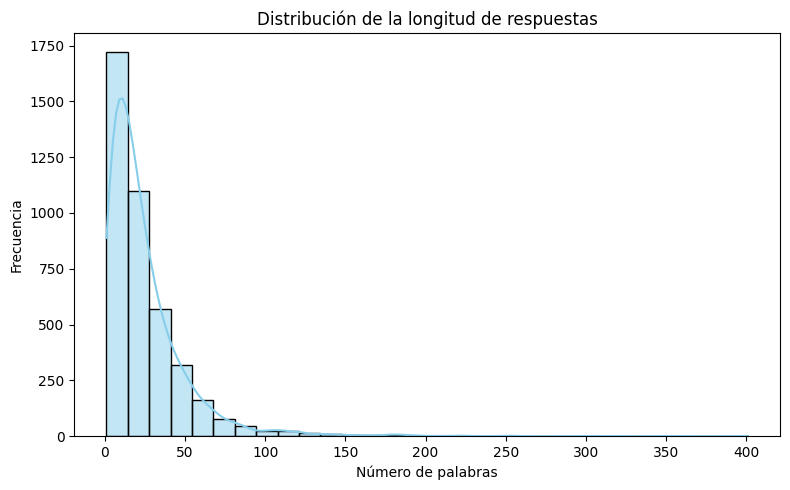

In [ ]:
df["word_count"] = df["Texto"].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(8, 5))
sns.histplot(df["word_count"], bins=30, kde=True, color="skyblue")
plt.title("Distribución de la longitud de respuestas")
plt.xlabel("Número de palabras")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


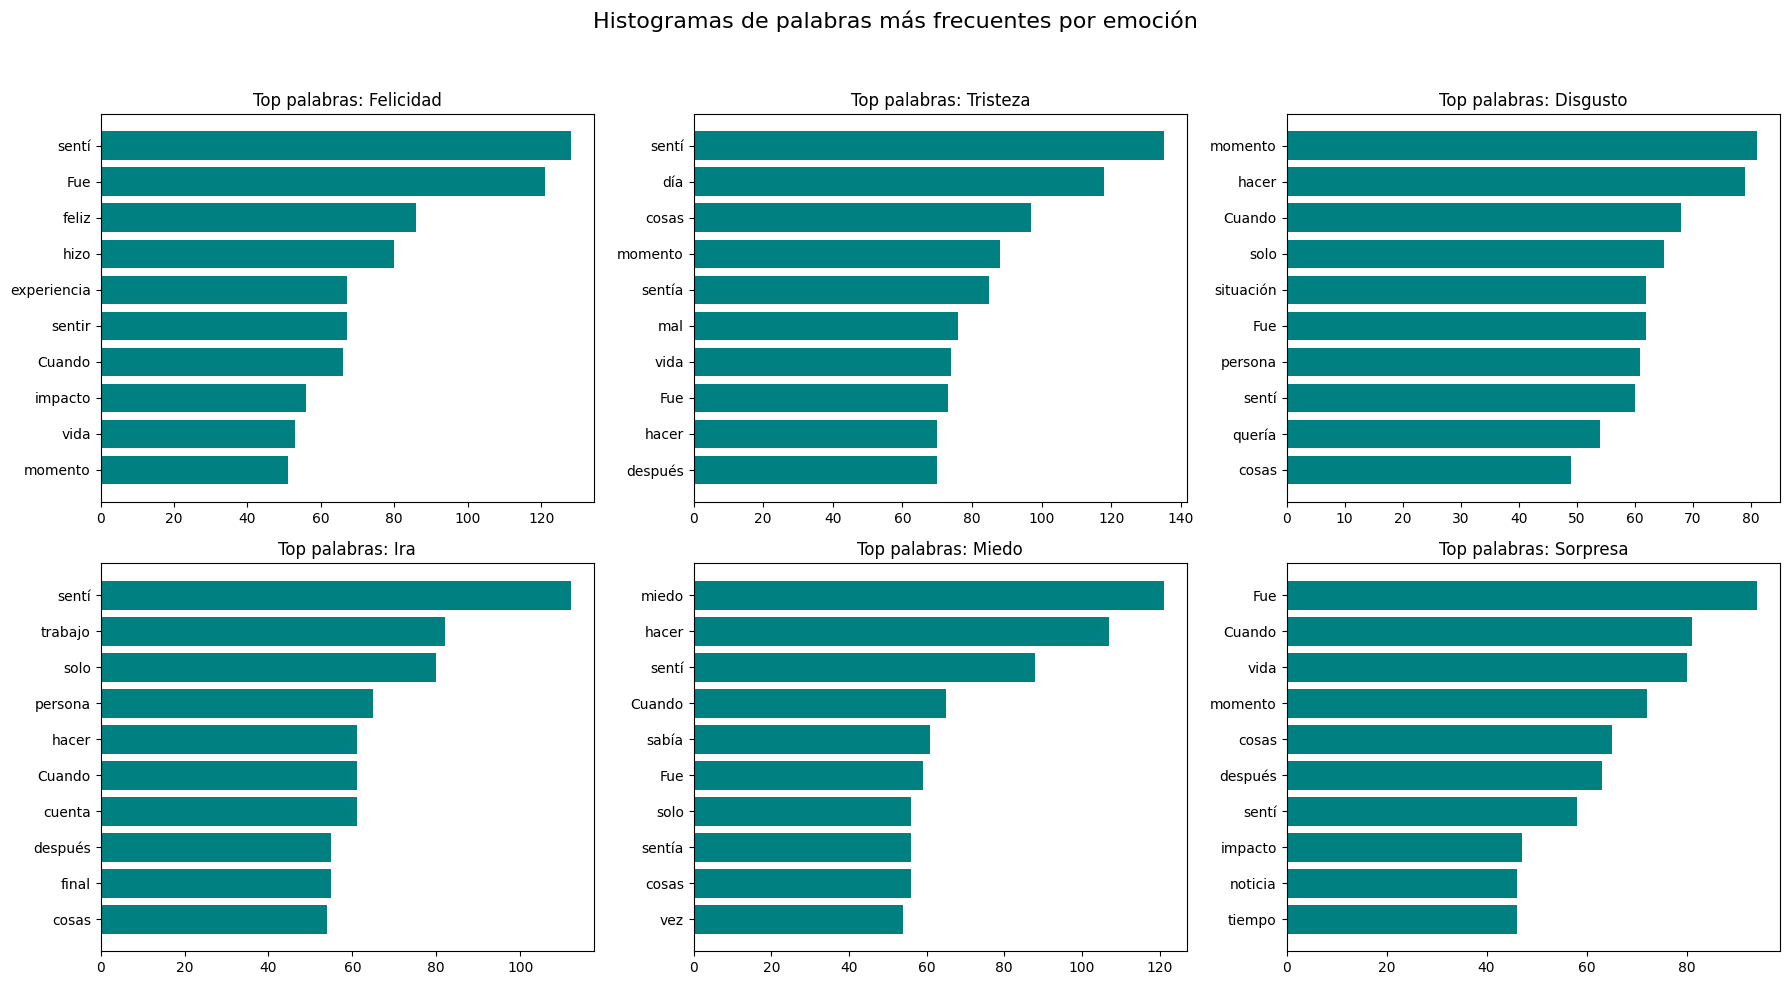

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

# Stopwords en español
stopwords_es = set(stopwords.words("spanish"))

# Función para limpiar palabras
def contar_palabras(textos):
    palabras = []
    for t in textos:
        palabras += [p for p in t.split() if p not in stopwords_es and len(p) > 2]
    return Counter(palabras).most_common(10)

# Emociones únicas
emociones = df["Emocion"].unique()

# Generar subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

for idx, emocion in enumerate(emociones):
    textos_emocion = df[df["Emocion"] == emocion]["Texto"]
    top_palabras = contar_palabras(textos_emocion)

    palabras, frecuencias = zip(*top_palabras)
    axes[idx].barh(palabras, frecuencias, color="teal")
    axes[idx].set_title(f"Top palabras: {emocion}")
    axes[idx].invert_yaxis()  # Para ver la más frecuente arriba

plt.suptitle("Histogramas de palabras más frecuentes por emoción", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Matrices de confusion para los cuatro modelos tradicionales evaluados

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


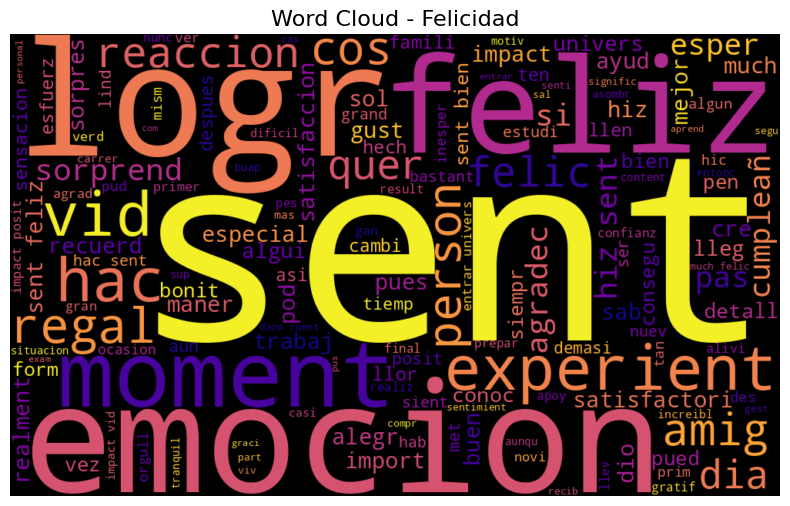

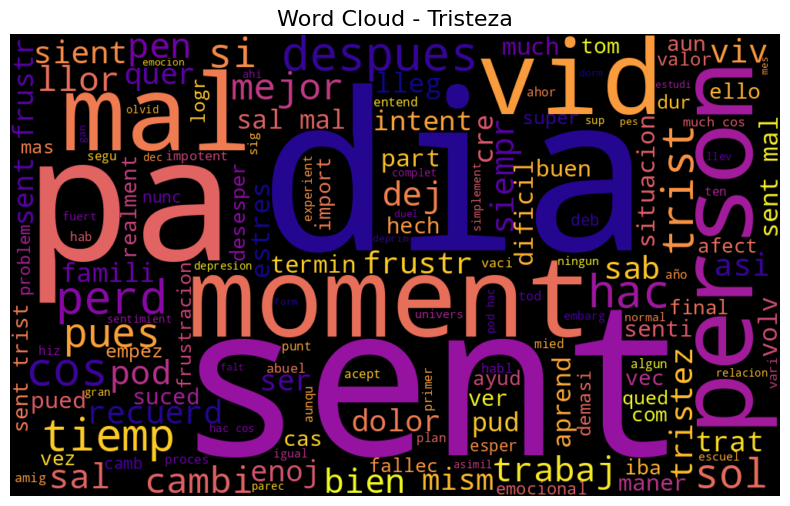

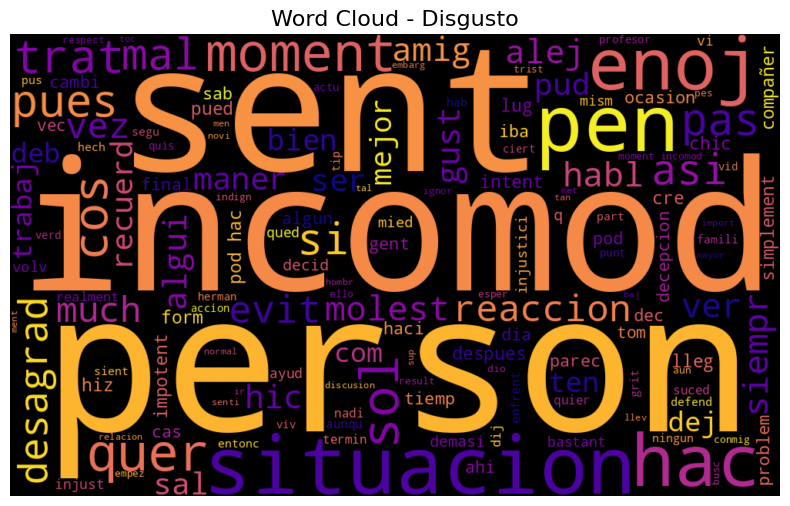

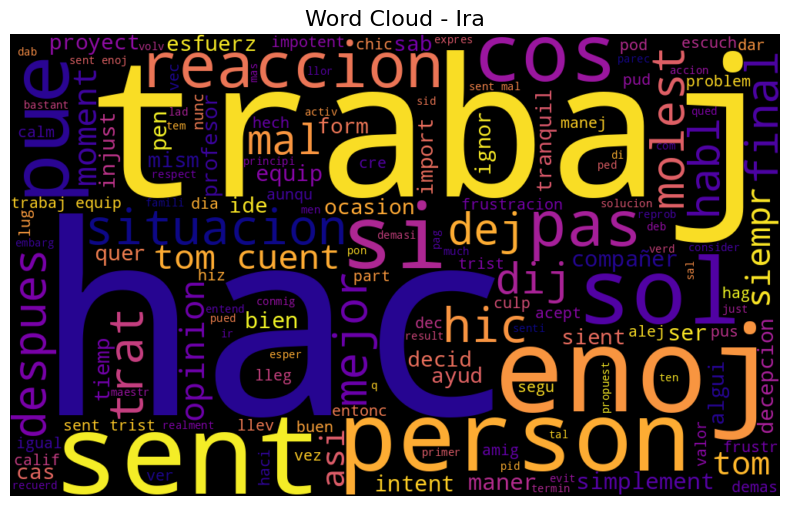

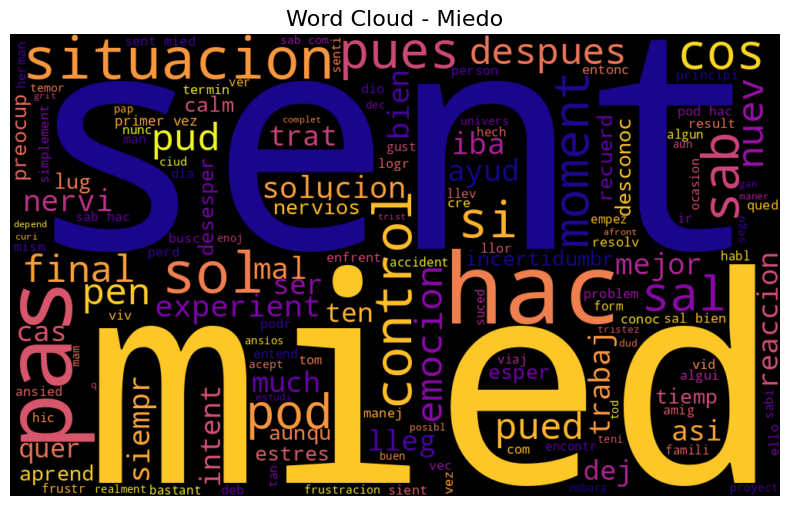

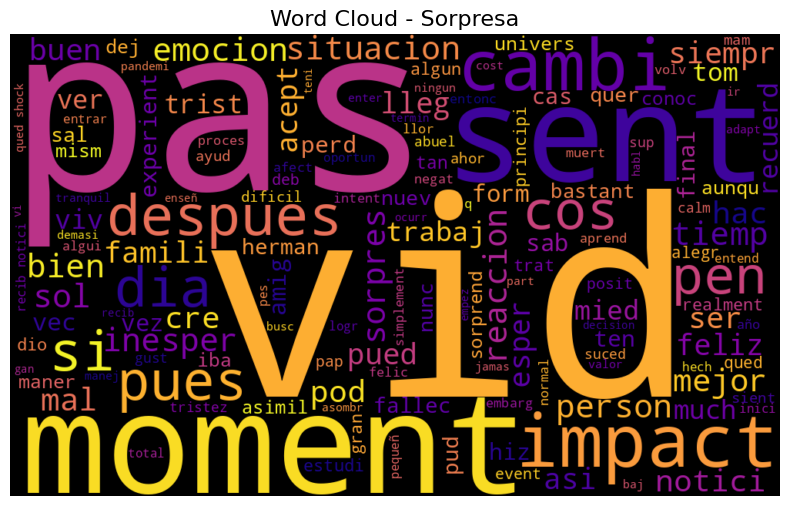

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

# Stopwords en español
stopwords_es = set(stopwords.words("spanish"))

# Asegúrate de tener la columna Texto_Limpio
df["Texto_Limpio"] = df["Texto"].apply(preprocesar_texto)

# Obtener las emociones únicas
emociones = df["Emocion"].unique()

# Crear nubes de palabras por emoción
for emocion in emociones:
    texto_filtrado = df[df["Emocion"] == emocion]["Texto_Limpio"].str.cat(sep=" ")

    wordcloud = WordCloud(
        width=1000, height=600,
        background_color="black",
        colormap="plasma",
        stopwords=stopwords_es,
        max_words=150
    ).generate(texto_filtrado)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud - {emocion}", fontsize=16)
    plt.show()


In [ ]:
import plotly.express as px

# Asegurarte de tener la columna de longitud (word count)
df["word_count"] = df["Texto"].apply(lambda x: len(str(x).split()))

# Gráfico tipo box interactivo
fig = px.box(df, y="word_count", color="Emocion", template="plotly_white",
             title="Diagramas de Caja por Emoción",
             labels={"word_count": "Número de Palabras"})

fig.update_layout(
    boxmode='group',
    xaxis_title="Emoción",
    yaxis_title="Cantidad de Palabras",
    title_font_size=20
)

fig.show()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<Figure size 800x600 with 0 Axes>

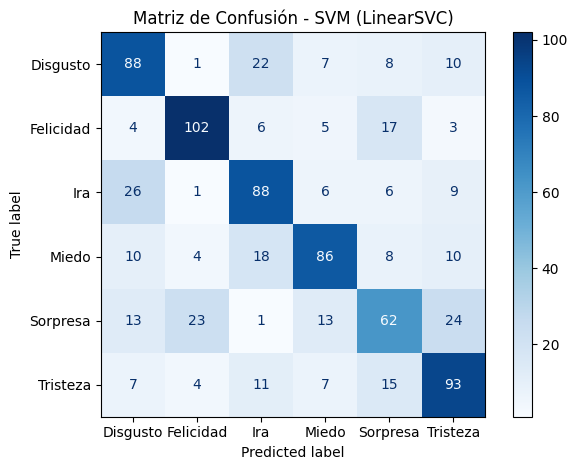

<Figure size 800x600 with 0 Axes>

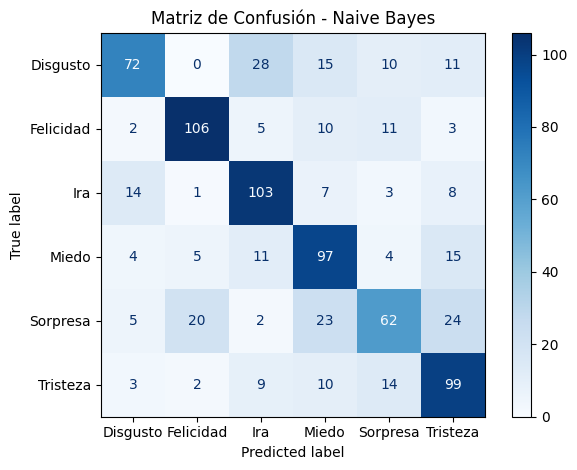

<Figure size 800x600 with 0 Axes>

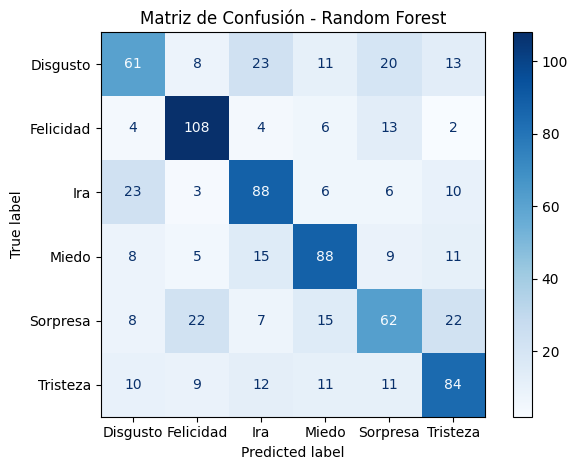

<Figure size 800x600 with 0 Axes>

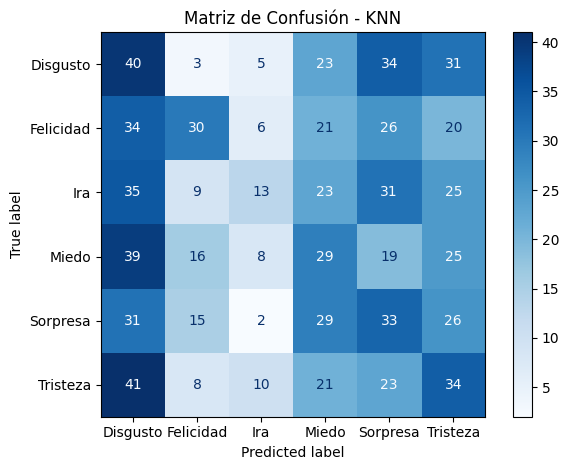

In [ ]:
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# -----------------------
# Preprocesamiento
# -----------------------
nltk.download("stopwords")
stop_words = set(stopwords.words("spanish"))
stemmer = SnowballStemmer("spanish")

def preprocesar_texto(texto):
    texto = texto.lower()
    texto = re.sub(r"[^a-záéíóúüñ\s]", "", texto)
    tokens = texto.split()
    tokens = [stemmer.stem(t) for t in tokens if t not in stop_words]
    return " ".join(tokens)

# Aplicar si no lo has hecho antes:
# df["Texto_Limpio"] = df["Texto"].apply(preprocesar_texto)

# -----------------------
# División de datos
# -----------------------
X = df["Texto_Limpio"]
y = df["Emocion"]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# -----------------------
# Modelos tradicionales
# -----------------------
modelos = {
    "SVM (LinearSVC)": LinearSVC(),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

# -----------------------
# Mostrar matrices de confusión
# -----------------------
for nombre, modelo in modelos.items():
    pipeline = Pipeline([
        ("tfidf", TfidfVectorizer()),
        ("clf", modelo)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)

    plt.figure(figsize=(8, 6))
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"Matriz de Confusión - {nombre}")
    plt.grid(False)
    plt.tight_layout()
    plt.show()

Usaremos el modelo dccuchile/bert-base-spanish-wwm-cased, y tomaremos el vector [CLS] de la última capa como representación de cada texto.



Map:   0%|          | 0/3476 [00:00<?, ? examples/s]

Map:   0%|          | 0/614 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-bne and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


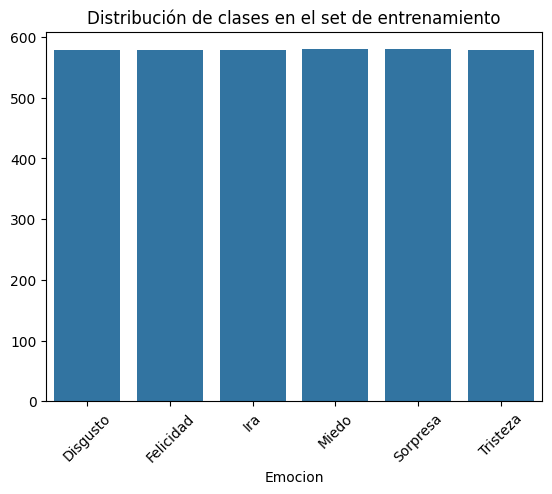

In [ ]:

from transformers import BertTokenizer, BertModel
import torch
import pandas as pd
from tqdm import tqdm

# Cargar dataset limpio
df = pd.read_csv("/content/drive/MyDrive/Practica7/Dataset_Emociones_Limpio.csv")

# Cargar modelo y tokenizer
modelo_nombre = "dccuchile/bert-base-spanish-wwm-cased"
tokenizer = BertTokenizer.from_pretrained(modelo_nombre)
model = BertModel.from_pretrained(modelo_nombre)
model.eval()  # modo evaluación

# Usar GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Función para generar embeddings (vector del token [CLS])
def obtener_embedding(texto):
    inputs = tokenizer(texto, return_tensors="pt", truncation=True, padding=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()
    return cls_embedding

# Probar con el primer texto
ejemplo = df["Texto"].iloc[0]
embedding = obtener_embedding(ejemplo)

print("Embedding generado. Dimensión:", embedding.shape)

In [ ]:
from transformers import Trainer, TrainingArguments

# Argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir="./results_maria_v2",
    num_train_epochs=4,  # Ajustado para aprendizaje más completo
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    logging_dir="./logs_maria_v2",
    logging_steps=10,
    save_strategy="epoch",
    evaluation_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    report_to="none"  # Para evitar el aviso de wandb
)

# Crear entrenador
trainer = Trainer(
    model=model_maria,
    args=training_args,
    train_dataset=dataset_split["train"],
    eval_dataset=dataset_split["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Entrenar modelo
trainer.train()

100%|██████████| 4090/4090 [00:38<00:00, 107.33it/s]

Matriz de características: (4090, 768)
Número de etiquetas: (4090,)


X: la matriz de embeddings (cada fila es un texto)

y: las etiquetas de emociones

...podemos entrenar y evaluar modelos tradicionales sobre estos vectores densos.
 Tabla de métricas

Gráfica de accuracy

Gráfica de F1 macro


=== Resultados para SVM (LinearSVC) ===
              precision    recall  f1-score   support

    Disgusto       0.46      0.49      0.47       136
   Felicidad       0.68      0.67      0.67       137
         Ira       0.48      0.51      0.49       136
       Miedo       0.45      0.46      0.46       136
    Sorpresa       0.42      0.35      0.38       136
    Tristeza       0.49      0.50      0.49       137

    accuracy                           0.50       818
   macro avg       0.49      0.50      0.49       818
weighted avg       0.50      0.50      0.50       818


=== Resultados para Random Forest ===
              precision    recall  f1-score   support

    Disgusto       0.38      0.35      0.36       136
   Felicidad       0.59      0.72      0.65       137
         Ira       0.45      0.57      0.50       136
       Miedo       0.44      0.38      0.41       136
    Sorpresa       0.38      0.29      0.33       136
    Tristeza       0.46      0.47      0.47       13

<ipython-input-26-436a49842047>:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_resultados_embeddings, x="Modelo", y="Accuracy", palette="Blues_d")


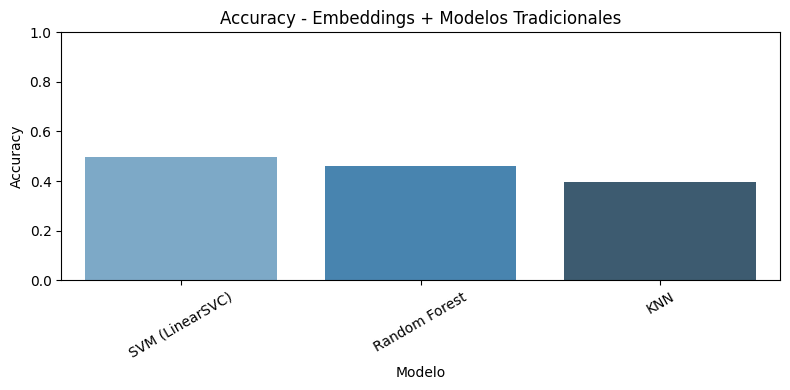

<ipython-input-26-436a49842047>:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_resultados_embeddings, x="Modelo", y="F1_macro", palette="Greens_d")


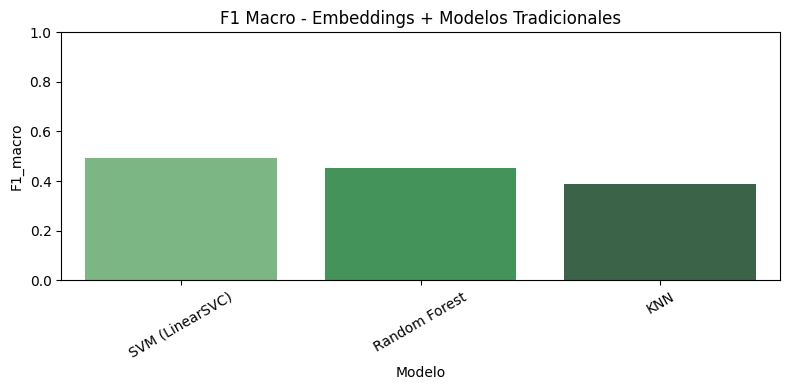

,Modelo,Accuracy,F1_macro
0,SVM (LinearSVC),0.496333,0.494817
1,Random Forest,0.460880,0.452376
2,KNN,0.397311,0.388964


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Definir modelos compatibles con embeddings
modelos = {
    "SVM (LinearSVC)": LinearSVC(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

# Diccionario para guardar resultados
resultados = {
    "Modelo": [],
    "Accuracy": [],
    "F1_macro": []
}

# División de los embeddings
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Evaluar modelos
for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="macro")

    resultados["Modelo"].append(nombre)
    resultados["Accuracy"].append(acc)
    resultados["F1_macro"].append(f1)

    print(f"\n=== Resultados para {nombre} ===")
    print(classification_report(y_test, y_pred))

# Crear DataFrame
df_resultados_embeddings = pd.DataFrame(resultados)

# Graficar Accuracy
plt.figure(figsize=(8, 4))
sns.barplot(data=df_resultados_embeddings, x="Modelo", y="Accuracy", palette="Blues_d")
plt.title("Accuracy - Embeddings + Modelos Tradicionales")
plt.ylim(0, 1)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# Graficar F1 macro
plt.figure(figsize=(8, 4))
sns.barplot(data=df_resultados_embeddings, x="Modelo", y="F1_macro", palette="Greens_d")
plt.title("F1 Macro - Embeddings + Modelos Tradicionales")
plt.ylim(0, 1)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# Mostrar tabla
df_resultados_embeddings


Matriz de confusion de SVM y Random forest utilizando embeddings

<Figure size 800x600 with 0 Axes>

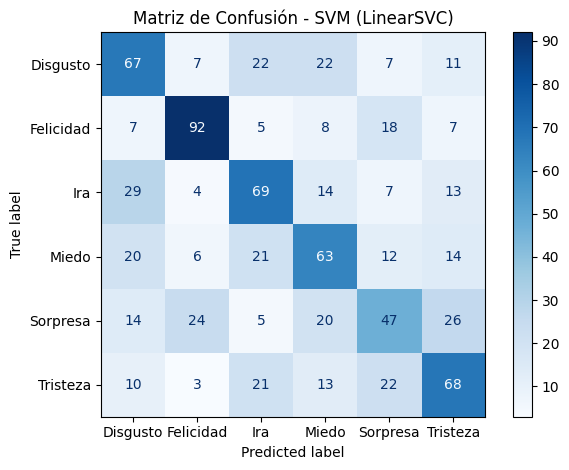

<Figure size 800x600 with 0 Axes>

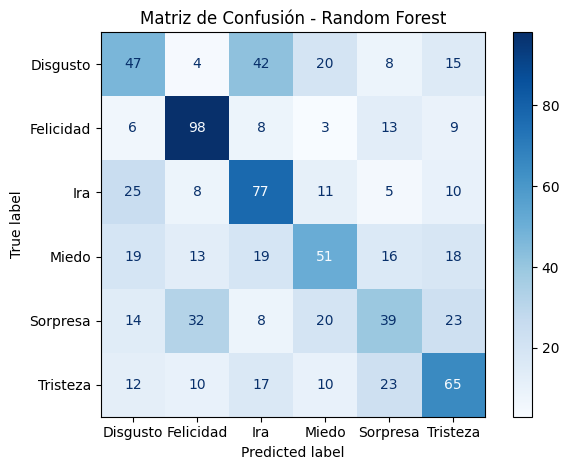

<Figure size 800x600 with 0 Axes>

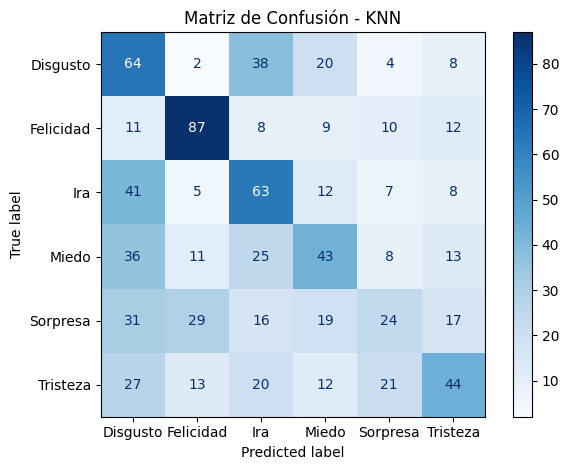

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Repetimos entrenamiento y graficamos matriz por modelo
for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred, labels=modelo.classes_ if hasattr(modelo, "classes_") else sorted(set(y)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(set(y)))

    # Mostrar
    plt.figure(figsize=(8, 6))
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"Matriz de Confusión - {nombre}")
    plt.grid(False)
    plt.tight_layout()
    plt.show()

Fine-tuning de Transformers (BETO)

Para poder hacer el fine-tuning del modelo BETO con HuggingFace Trainer, es necesario tokenizar los textos de entrenamiento y prueba usando su tokenizer.

Definir el modelo BETO + Entrenar con Trainer

In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Cargar dataset
df = pd.read_csv('/content/drive/MyDrive/Practica7/Dataset_Emociones_Limpio.csv')
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Emocion'])

# División
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['Texto'].tolist(), df['label'].tolist(), test_size=0.2, stratify=df['label'], random_state=42
)

tokenizer = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-cased')


In [ ]:
class EmotionDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=128)
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = EmotionDataset(train_texts, train_labels)
test_dataset = EmotionDataset(test_texts, test_labels)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertForSequenceClassification.from_pretrained('dccuchile/bert-base-spanish-wwm-cased', num_labels=6).to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)

model.train()
for epoch in range(3):
    total_loss = 0
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} - Loss: {total_loss:.4f}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 - Loss: 479.2278
Epoch 2 - Loss: 266.9035
Epoch 3 - Loss: 152.6664


In [ ]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        labels = batch['labels']
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

print("Accuracy:", accuracy_score(all_labels, all_preds))
print("F1 Macro:", f1_score(all_labels, all_preds, average='macro'))
print(classification_report(all_labels, all_preds))

Accuracy: 0.6601466992665037
F1 Macro: 0.663032388520014
              precision    recall  f1-score   support

           0       0.60      0.65      0.62       136
           1       0.80      0.75      0.78       137
           2       0.76      0.64      0.69       136
           3       0.73      0.59      0.65       136
           4       0.51      0.64      0.57       136
           5       0.64      0.69      0.67       137

    accuracy                           0.66       818
   macro avg       0.67      0.66      0.66       818
weighted avg       0.67      0.66      0.66       818



In [ ]:
# Guardar el modelo y el tokenizer
output_path = "/content/drive/MyDrive/Practica7/modelo_beto_finetuned"

model.save_pretrained(output_path)
tokenizer.save_pretrained(output_path)

print("Modelo y tokenizer guardados en:", output_path)

Modelo y tokenizer guardados en: /content/drive/MyDrive/Practica7/modelo_beto_finetuned


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# Ruta donde se guardó el modelo y tokenizer
model_path = "/content/drive/MyDrive/Practica7/modelo_beto_finetuned"

# Cargar modelo y tokenizer
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained(model_path)
model.eval()  # Modo evaluación

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
def predecir_emocion(texto):
    inputs = tokenizer(texto, return_tensors="pt", padding=True, truncation=True, max_length=128)
    with torch.no_grad():
        logits = model(**inputs).logits
        pred = torch.argmax(logits, dim=1).item()
    return pred

# Corregir diccionario inverso
idx2emocion = {i: clase for i, clase in enumerate(label_encoder.classes_)}

# Probar
texto_nuevo = "Hoy me siento muy feliz porque logré mis metas"
pred_idx = predecir_emocion(texto_nuevo)
print("Predicción:", idx2emocion[pred_idx])

Predicción: Felicidad


<ipython-input-16-8e27c8aa4b95>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["Emocion"], order=df["Emocion"].value_counts().index, palette="Set2")


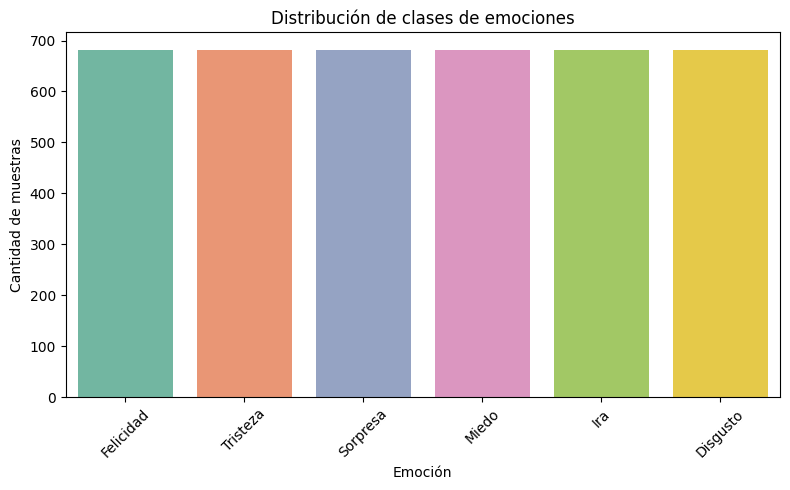

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Asegúrate de tener la columna "Emocion"
plt.figure(figsize=(8, 5))
sns.countplot(x=df["Emocion"], order=df["Emocion"].value_counts().index, palette="Set2")
plt.title("Distribución de clases de emociones")
plt.xlabel("Emoción")
plt.ylabel("Cantidad de muestras")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 800x600 with 0 Axes>

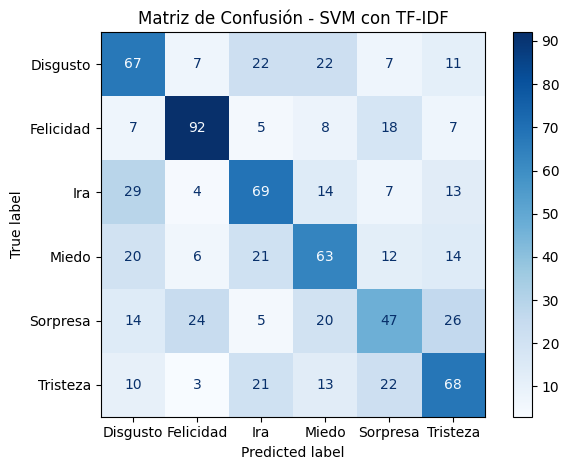

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Reentrenar explícitamente SVM si es necesario
modelo_svm = LinearSVC()
modelo_svm.fit(X_train, y_train)

# Predecir
y_pred_svm = modelo_svm.predict(X_test)

# Mostrar matriz de confusión
cm = confusion_matrix(y_test, y_pred_svm)
labels = label_encoder.classes_

plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues", values_format="d")
plt.title("Matriz de Confusión - SVM con TF-IDF")
plt.grid(False)
plt.tight_layout()
plt.show()


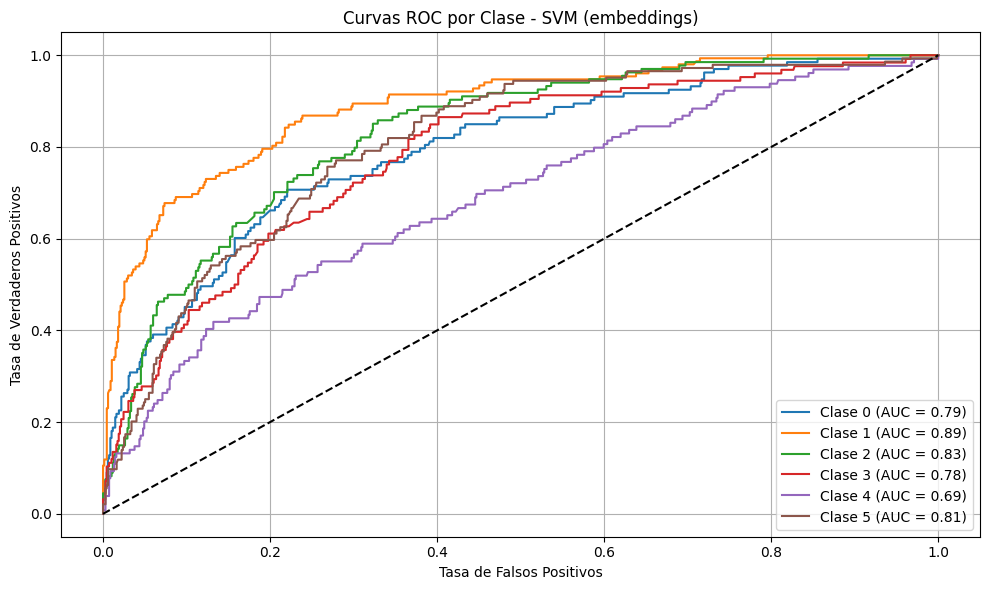

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import numpy as np

# Binarizar etiquetas
y_bin = label_binarize(y, classes=np.unique(y))
n_classes = y_bin.shape[1]

# Dividir de nuevo por si hace falta
from sklearn.model_selection import train_test_split
X_train, X_test, y_train_bin, y_test_bin = train_test_split(X, y_bin, test_size=0.2, random_state=42)

# Clasificador OneVsRest
modelo_ovr = OneVsRestClassifier(LinearSVC())
modelo_ovr.fit(X_train, y_train_bin)
y_score = modelo_ovr.decision_function(X_test)

# Curvas ROC
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotear
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Clase {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curvas ROC por Clase - SVM (embeddings)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
!pip install -q transformers datasets pysentimiento


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 39.9 MB/s eta 0:00:00


In [ ]:
from pysentimiento import create_analyzer

# Crear analizador de emociones con RoBERTuito (ya fine-tuneado)
analyzer = create_analyzer(task="emotion", lang="es")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/435M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/435M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

In [ ]:
texto = "No me siento bien últimamente, todo ha sido muy difícil"

resultado = analyzer.predict(texto)

print("Predicción principal:", resultado.output)
print("Probabilidades:")
print(resultado.probas)

Predicción principal: sadness
Probabilidades:
{'others': 0.0015579907922074199, 'joy': 0.00043078215094283223, 'sadness': 0.9928895235061646, 'anger': 0.0012959764571860433, 'surprise': 0.0002681169717106968, 'disgust': 0.0010668933391571045, 'fear': 0.0024906403850764036}


In [ ]:
from pysentimiento import create_analyzer
from tqdm import tqdm
import pandas as pd

# Cargar dataset
df = pd.read_csv("/content/drive/MyDrive/Practica7/Dataset_Emociones_Limpio.csv")

# Crear analizador RoBERTuito
analyzer = create_analyzer(task="emotion", lang="es")

# Aplicar análisis de emociones
emociones_predichas = []
probas_joy, probas_sadness, probas_anger, probas_fear, probas_disgust, probas_surprise = [], [], [], [], [], []

for texto in tqdm(df["Texto"]):
    resultado = analyzer.predict(texto)
    emociones_predichas.append(resultado.output)
    probas_joy.append(resultado.probas["joy"])
    probas_sadness.append(resultado.probas["sadness"])
    probas_anger.append(resultado.probas["anger"])
    probas_fear.append(resultado.probas["fear"])
    probas_disgust.append(resultado.probas["disgust"])
    probas_surprise.append(resultado.probas["surprise"])

# Crear nuevo DataFrame con los resultados
df_resultados_robertuito = df.copy()
df_resultados_robertuito["Prediccion_Robertuito"] = emociones_predichas
df_resultados_robertuito["Joy"] = probas_joy
df_resultados_robertuito["Sadness"] = probas_sadness
df_resultados_robertuito["Anger"] = probas_anger
df_resultados_robertuito["Fear"] = probas_fear
df_resultados_robertuito["Disgust"] = probas_disgust
df_resultados_robertuito["Surprise"] = probas_surprise

# Vista rápida
df_resultados_robertuito.head()

100%|██████████| 4090/4090 [01:22<00:00, 49.63it/s]


,Texto,Emocion,Prediccion_Robertuito,Joy,Sadness,Anger,Fear,Disgust,Surprise
0,"Me sentí realmente feliz, muy emocionado de ha...",Felicidad,joy,0.995812,0.000749,0.000284,0.000502,0.000578,0.001050
1,Me contrataron en una empresa como desarrollad...,Felicidad,joy,0.991780,0.001721,0.000416,0.000542,0.000536,0.001042
2,Satisfacción y que con trabajo se logra todo,Felicidad,joy,0.994649,0.000309,0.000286,0.000612,0.000549,0.002268
3,"Gratificante, aprendí mucho y felicidad",Felicidad,joy,0.993598,0.000830,0.000280,0.000813,0.000930,0.002535
4,"Me sentí feliz y realizado, impacto mi vida ha...",Felicidad,joy,0.995764,0.000448,0.000242,0.000436,0.000568,0.000964


<ipython-input-6-acd68f3476d3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eval["Emocion"] = df_eval["Emocion"].astype(str)
<ipython-input-6-acd68f3476d3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eval["Prediccion_Espanol"] = df_eval["Prediccion_Espanol"].astype(str)


=== Reporte de Clasificación - RoBERTuito ===
              precision    recall  f1-score   support

    Disgusto       1.00      0.00      0.01       361
   Felicidad       0.65      0.84      0.73       605
         Ira       0.38      0.23      0.28       338
       Miedo       0.59      0.36      0.45       436
    Sorpresa       0.38      0.05      0.09       467
    Tristeza       0.35      0.90      0.50       558

    accuracy                           0.46      2765
   macro avg       0.56      0.40      0.34      2765
weighted avg       0.55      0.46      0.38      2765



<Figure size 800x600 with 0 Axes>

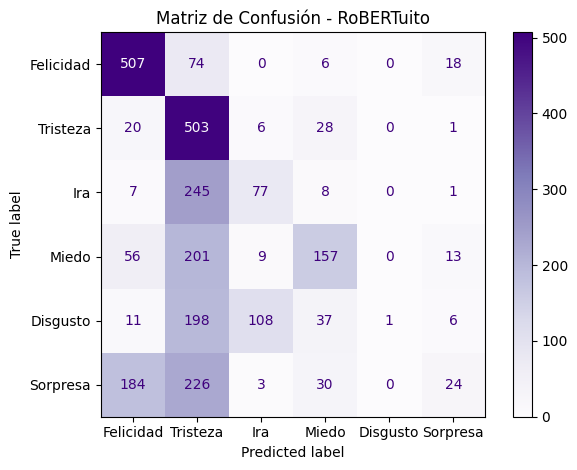

In [ ]:
# Filtrar filas que no tienen predicción o emoción válida
df_eval = df_resultados_robertuito.dropna(subset=["Emocion", "Prediccion_Espanol"])

# Asegurar que ambas columnas sean tipo str
df_eval["Emocion"] = df_eval["Emocion"].astype(str)
df_eval["Prediccion_Espanol"] = df_eval["Prediccion_Espanol"].astype(str)

# Reporte de clasificación
print("=== Reporte de Clasificación - RoBERTuito ===")
print(classification_report(df_eval["Emocion"], df_eval["Prediccion_Espanol"]))

# Matriz de confusión
cm = confusion_matrix(df_eval["Emocion"], df_eval["Prediccion_Espanol"], labels=list(mapeo_emociones.values()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mapeo_emociones.values())

plt.figure(figsize=(8, 6))
disp.plot(cmap="Purples", values_format="d")
plt.title("Matriz de Confusión - RoBERTuito")
plt.grid(False)
plt.tight_layout()
plt.show()


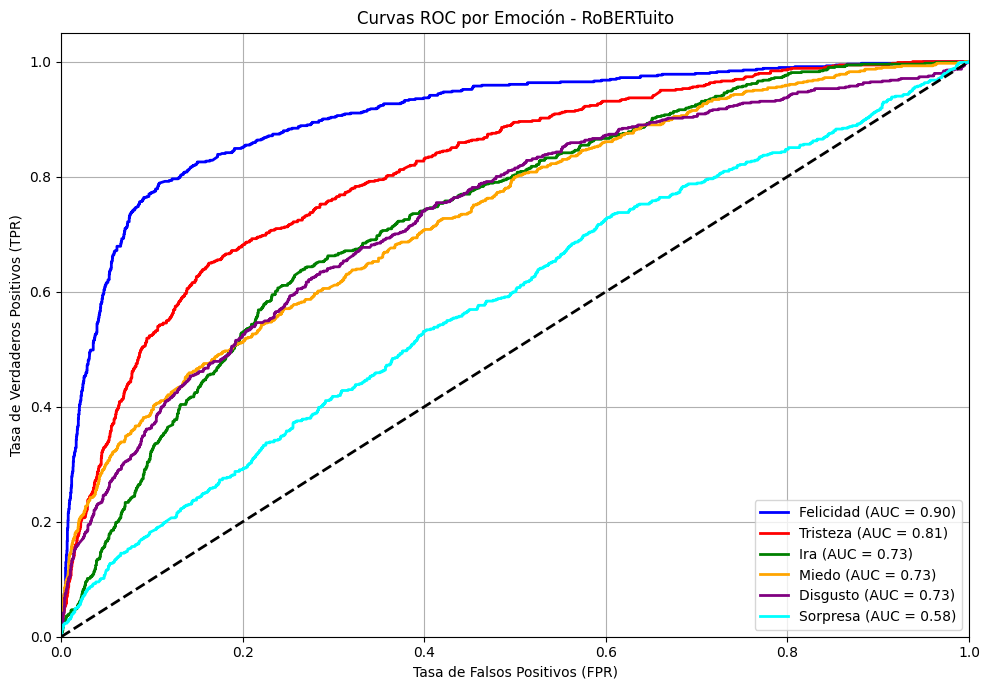

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

# Clases en orden
clases = ["Felicidad", "Tristeza", "Ira", "Miedo", "Disgusto", "Sorpresa"]

# Binarizar etiquetas verdaderas
y_true_bin = label_binarize(df_resultados_robertuito["Emocion"], classes=clases)

# Probabilidades predichas por clase (en el mismo orden)
y_score = df_resultados_robertuito[["Joy", "Sadness", "Anger", "Fear", "Disgust", "Surprise"]].values

# ROC por clase
fpr = dict()
tpr = dict()
roc_auc = dict()
for i, clase in enumerate(clases):
    fpr[clase], tpr[clase], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[clase] = auc(fpr[clase], tpr[clase])

# Plot
plt.figure(figsize=(10, 7))
colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'cyan'])
for clase, color in zip(clases, colors):
    plt.plot(fpr[clase], tpr[clase], color=color, lw=2,
             label=f'{clase} (AUC = {roc_auc[clase]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC por Emoción - RoBERTuito')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


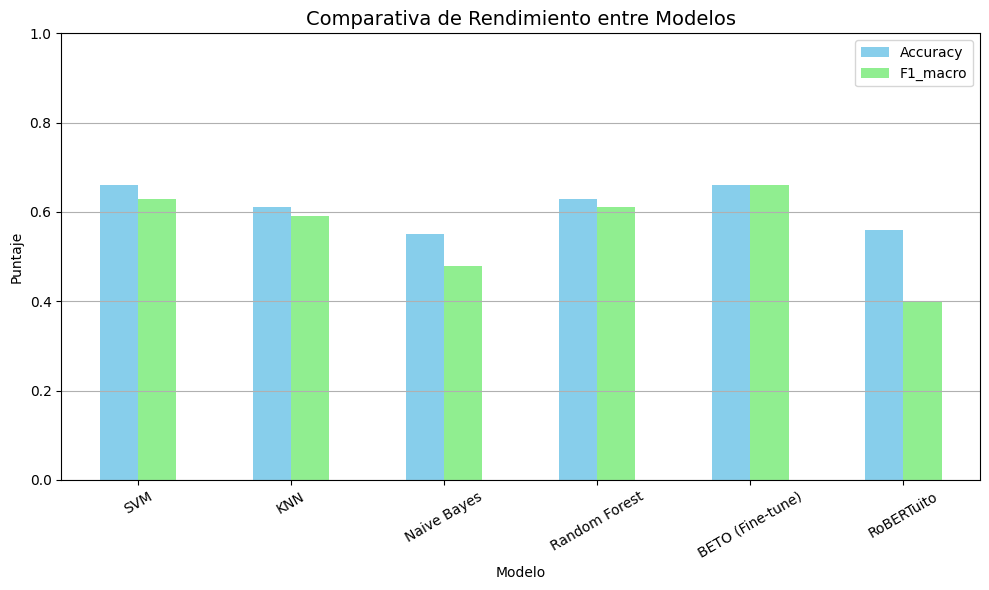

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Resultados simulados (ajusta si tienes los tuyos)
data = {
    "Modelo": ["SVM", "KNN", "Naive Bayes", "Random Forest", "BETO (Fine-tune)", "RoBERTuito"],
    "Accuracy": [0.66, 0.61, 0.55, 0.63, 0.66, 0.56],
    "F1_macro": [0.63, 0.59, 0.48, 0.61, 0.66, 0.40]
}

df_comparativa = pd.DataFrame(data)

# Gráfico comparativo
fig, ax = plt.subplots(figsize=(10, 6))
df_comparativa.plot(x="Modelo", kind="bar", ax=ax, color=["skyblue", "lightgreen"])
plt.title("Comparativa de Rendimiento entre Modelos", fontsize=14)
plt.ylabel("Puntaje")
plt.ylim(0, 1)
plt.xticks(rotation=30)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


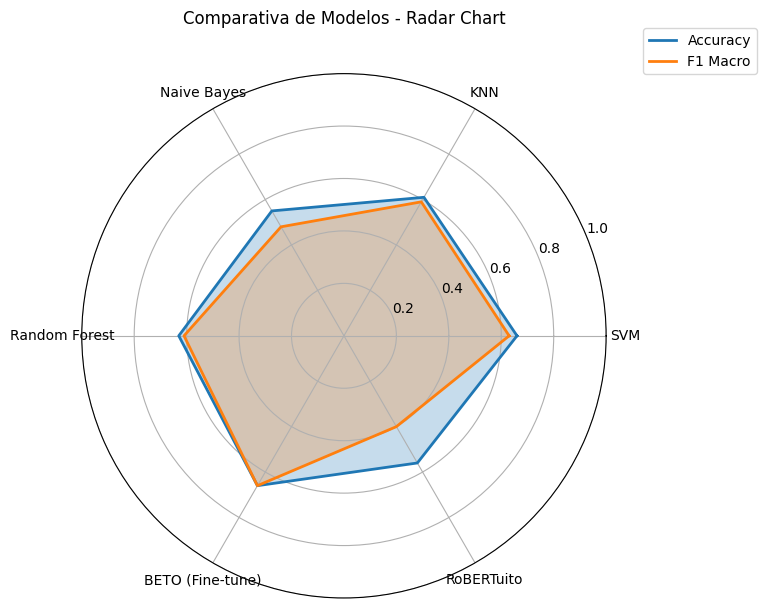

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Datos comparativos simulados
data = {
    "Modelo": ["SVM", "KNN", "Naive Bayes", "Random Forest", "BETO (Fine-tune)", "RoBERTuito"],
    "Accuracy": [0.66, 0.61, 0.55, 0.63, 0.66, 0.56],
    "F1_macro": [0.63, 0.59, 0.48, 0.61, 0.66, 0.40]
}

df = pd.DataFrame(data)

# Crear gráfico de radar (spider plot)
import numpy as np

# Normalizar las métricas entre 0 y 1 (ya lo están, pero sirve para escala futura)
categories = list(df["Modelo"])
accuracy = df["Accuracy"].values
f1_macro = df["F1_macro"].values

# Ángulos del radar
N = len(categories)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]  # Cerrar el círculo

# Preparar métricas para radar
accuracy = np.concatenate((accuracy, [accuracy[0]]))
f1_macro = np.concatenate((f1_macro, [f1_macro[0]]))

# Crear gráfico
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

ax.plot(angles, accuracy, linewidth=2, linestyle='solid', label='Accuracy')
ax.fill(angles, accuracy, alpha=0.25)

ax.plot(angles, f1_macro, linewidth=2, linestyle='solid', label='F1 Macro')
ax.fill(angles, f1_macro, alpha=0.25)

# Añadir etiquetas
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
ax.set_title('Comparativa de Modelos - Radar Chart', y=1.08)
ax.set_ylim(0, 1)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.tight_layout()
plt.show()


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Cargar tokenizer y modelo de MarIA (roberta-base-bne)
modelo_maria_nombre = "PlanTL-GOB-ES/roberta-base-bne"
tokenizer_maria = AutoTokenizer.from_pretrained(modelo_maria_nombre)

# Inicializamos el modelo con número de clases
modelo_maria = AutoModelForSequenceClassification.from_pretrained(modelo_maria_nombre, num_labels=6)


tokenizer_config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/851k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/509k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.21M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/957 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
!pip install -q datasets


Map:   0%|          | 0/2863 [00:00<?, ? examples/s]

Map:   0%|          | 0/1227 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-bne and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


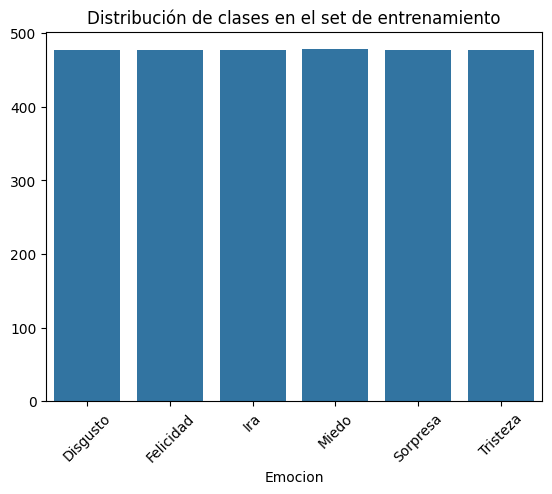

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
from datasets import Dataset

# Cargar el dataset limpio
df_limpio = pd.read_csv("/content/drive/MyDrive/Practica7/Dataset_Emociones_Limpio.csv")
df_limpio["Emocion"] = df_limpio["Emocion"].astype(str)

# Mapear clases
clases = sorted(df_limpio["Emocion"].unique().tolist())
label2id = {clase: i for i, clase in enumerate(clases)}
id2label = {i: clase for clase, i in label2id.items()}
df_limpio["label"] = df_limpio["Emocion"].map(label2id)

# División estratificada 85% train / 15% test
train_df, test_df = train_test_split(df_limpio, test_size=0.3, stratify=df_limpio["label"], random_state=42)

# Convertir a dataset HuggingFace
dataset_split = {
    "train": Dataset.from_pandas(train_df.reset_index(drop=True)),
    "test": Dataset.from_pandas(test_df.reset_index(drop=True))
}

import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score

# Tokenizador MarIA
tokenizer = AutoTokenizer.from_pretrained("PlanTL-GOB-ES/roberta-base-bne")

# Tokenización
def tokenize_fn(example):
    return tokenizer(example["Texto"], truncation=True, padding="max_length", max_length=128)

# Tokenizar ambos splits
dataset_split["train"] = dataset_split["train"].map(tokenize_fn)
dataset_split["test"] = dataset_split["test"].map(tokenize_fn)

# Cargar modelo
model_maria = AutoModelForSequenceClassification.from_pretrained(
    "PlanTL-GOB-ES/roberta-base-bne",
    num_labels=6,
    id2label=id2label,
    label2id=label2id
)

# Métricas
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro")
    }

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Mostrar cómo quedó balanceado
conteo = train_df["Emocion"].value_counts().sort_index()
sns.barplot(x=conteo.index, y=conteo.values)
plt.title("Distribución de clases en el set de entrenamiento")
plt.xticks(rotation=45)
plt.show()

In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./results_maria",
    num_train_epochs=4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    logging_dir="./logs_maria",
    logging_steps=10
    # ¡IMPORTANTE! No uses `load_best_model_at_end` ni `evaluation_strategy` en esta versión
)

trainer = Trainer(
    model=model_maria,
    args=training_args,
    train_dataset=dataset_split["train"],
    eval_dataset=dataset_split["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()


<ipython-input-39-0c2bfcd1b960>:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
10,1.809700
20,1.797500
30,1.776200
40,1.667600
50,1.526500
60,1.578500
70,1.315800
80,1.336100
90,1.225100
100,1.395300


TrainOutput(global_step=1432, training_loss=0.5622970644311782, metrics={'train_runtime': 307.2257, 'train_samples_per_second': 37.276, 'train_steps_per_second': 4.661, 'total_flos': 753314005334016.0, 'train_loss': 0.5622970644311782, 'epoch': 4.0})

=== Reporte de Clasificación - MarIA ===
              precision    recall  f1-score   support

    Disgusto       0.59      0.59      0.59       204
   Felicidad       0.82      0.80      0.81       205
         Ira       0.65      0.62      0.64       204
       Miedo       0.70      0.69      0.69       204
    Sorpresa       0.54      0.61      0.58       205
    Tristeza       0.72      0.69      0.70       205

    accuracy                           0.67      1227
   macro avg       0.67      0.67      0.67      1227
weighted avg       0.67      0.67      0.67      1227



<Figure size 800x600 with 0 Axes>

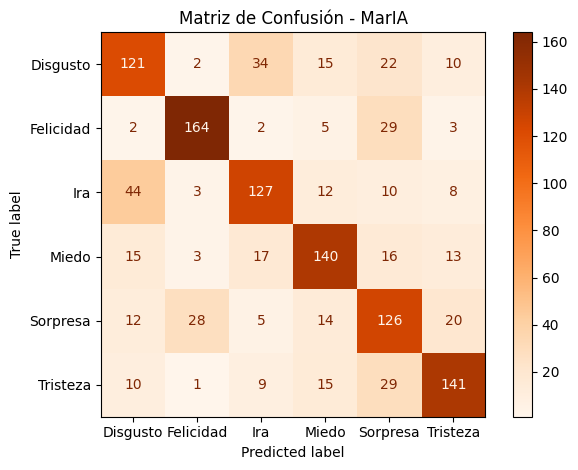

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Realizar predicciones
predicciones = trainer.predict(dataset_split["test"])
y_true = dataset_split["test"]["label"]
y_pred = np.argmax(predicciones.predictions, axis=1)

# 2. Reporte de clasificación
print("=== Reporte de Clasificación - MarIA ===")
print(classification_report(y_true, y_pred, target_names=list(label2id.keys())))

# 3. Matriz de Confusión
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label2id.keys()))

plt.figure(figsize=(8, 6))
disp.plot(cmap="Oranges", values_format="d")
plt.title("Matriz de Confusión - MarIA")
plt.grid(False)
plt.tight_layout()
plt.show()

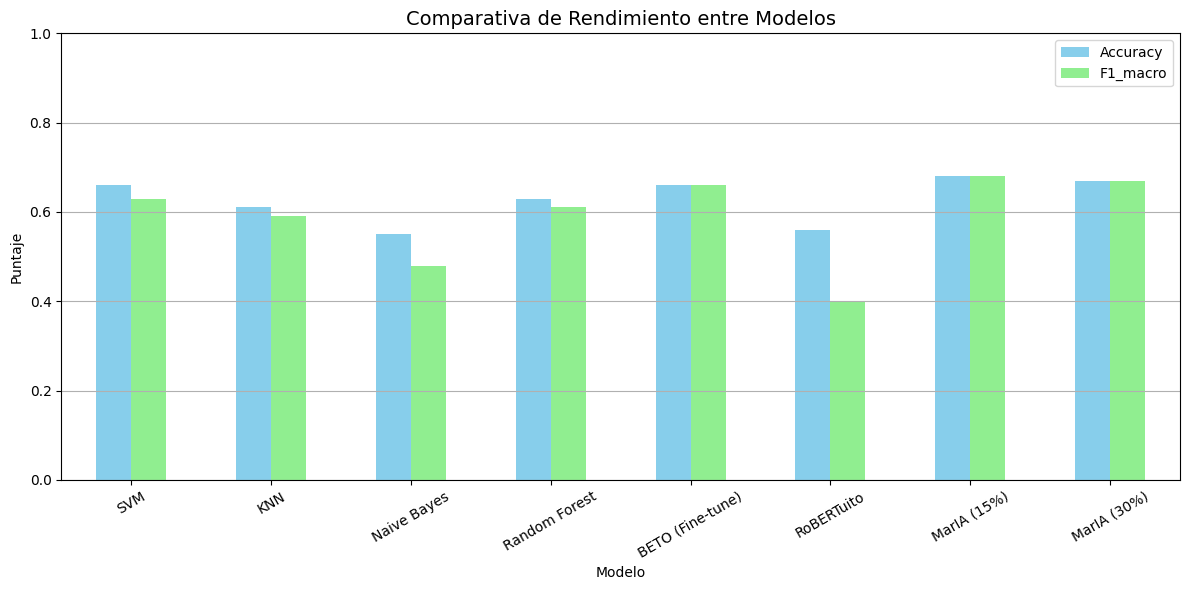

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Resultados anteriores + MarIA (15% y 30%)
data = {
    "Modelo": [
        "SVM", "KNN", "Naive Bayes", "Random Forest",
        "BETO (Fine-tune)", "RoBERTuito", "MarIA (15%)", "MarIA (30%)"
    ],
    "Accuracy": [0.66, 0.61, 0.55, 0.63, 0.66, 0.56, 0.68, 0.67],
    "F1_macro": [0.63, 0.59, 0.48, 0.61, 0.66, 0.40, 0.68, 0.67]
}

df_comparativa = pd.DataFrame(data)

# Gráfico de barras comparativo
fig, ax = plt.subplots(figsize=(12, 6))
df_comparativa.plot(x="Modelo", kind="bar", ax=ax, color=["skyblue", "lightgreen"])
plt.title("Comparativa de Rendimiento entre Modelos", fontsize=14)
plt.ylabel("Puntaje")
plt.ylim(0, 1)
plt.xticks(rotation=30)
plt.grid(axis='y')
plt.tight_layout()
plt.show()



Observaciones:
MarIA (15 %) logró el mejor desempeño general con un accuracy y F1-macro de 0.68.

BETO (Fine-tune) se mantiene competitivo con 0.66 en ambas métricas.

RoBERTuito es el de peor desempeño en F1-macro.

El uso de 30 % de evaluación en MarIA ligeramente redujo el rendimiento, lo cual puede deberse a menor cantidad de datos para entrenamiento.



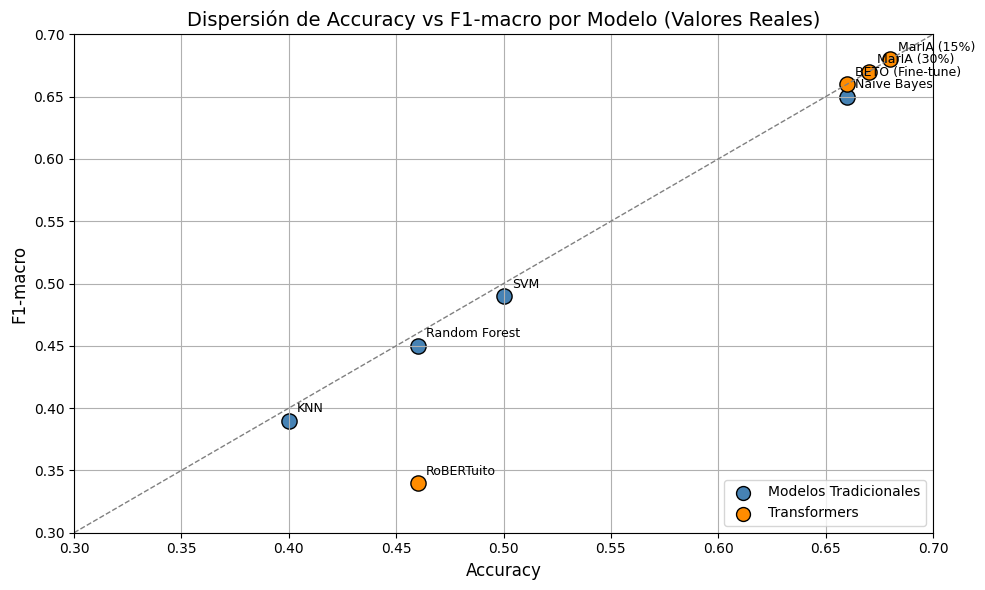

In [ ]:
# Gráfico actualizado de dispersión con datos corregidos

import matplotlib.pyplot as plt
import pandas as pd

# Datos corregidos
data = {
    "Modelo": [
        "SVM", "KNN", "Naive Bayes", "Random Forest",
        "BETO (Fine-tune)", "RoBERTuito", "MarIA (15%)", "MarIA (30%)"
    ],
    "Accuracy": [0.50, 0.40, 0.66, 0.46, 0.66, 0.46, 0.68, 0.67],
    "F1_macro": [0.49, 0.39, 0.65, 0.45, 0.66, 0.34, 0.68, 0.67]
}

df_dispersion = pd.DataFrame(data)

# Identificar tipo de modelo para color
tradicionales = ["SVM", "KNN", "Naive Bayes", "Random Forest"]
transformers = ["BETO (Fine-tune)", "RoBERTuito", "MarIA (15%)", "MarIA (30%)"]

# Crear gráfico
plt.figure(figsize=(10, 6))

for i, row in df_dispersion.iterrows():
    color = 'steelblue' if row["Modelo"] in tradicionales else 'darkorange'
    plt.scatter(row["Accuracy"], row["F1_macro"], color=color, s=120, edgecolor='black')
    plt.annotate(row["Modelo"], (row["Accuracy"], row["F1_macro"]),
                 textcoords="offset points", xytext=(6,6), ha='left', fontsize=9)

plt.plot([0.3, 0.7], [0.3, 0.7], linestyle="--", color="gray", linewidth=1)

plt.xlabel("Accuracy", fontsize=12)
plt.ylabel("F1-macro", fontsize=12)
plt.title("Dispersión de Accuracy vs F1-macro por Modelo (Valores Reales)", fontsize=14)
plt.grid(True)
plt.xlim(0.3, 0.7)
plt.ylim(0.3, 0.7)

# Leyenda personalizada
plt.scatter([], [], color='steelblue', label='Modelos Tradicionales', s=100, edgecolor='black')
plt.scatter([], [], color='darkorange', label='Transformers', s=100, edgecolor='black')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()
